# Task 2 - Predictive Analysis

This is my solutions for predictive analysis task in data ANZ virtual internship program. The objectives are:
*   Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.
*   Build a simple regression model to predict the annual salary for each customer 
*   Build a decision-tree based model to predict salary





## Import library

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

## Data Cleaning and Preparation

### Import Data

In [ ]:
df = pd.read_excel('/content/ANZ synthesised transaction dataset.xlsx')
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


### Filter out transaction type other than PAY/SALARY

In [ ]:
salary_df = df[df['txn_description'] == 'PAY/SALARY']
salary_df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
50,posted,NaN,0,ACC-588564840,AUD,151.27 -33.76,PAY/SALARY,NaN,0.0,Isaiah,8342.11,2018-08-01,M,23,NaN,NaN,2018-08-01T11:00:00.000+0000,3903.95,9ca281650e5d482d9e53f85e959baa66,Australia,CUS-1462656821,NaN,credit
61,posted,NaN,0,ACC-1650504218,AUD,145.01 -37.93,PAY/SALARY,NaN,0.0,Marissa,2040.58,2018-08-01,F,23,NaN,NaN,2018-08-01T12:00:00.000+0000,1626.48,1822eb0e1bbe4c9e95ebbb0fa2cc4323,Australia,CUS-2500783281,NaN,credit
64,posted,NaN,0,ACC-3326339947,AUD,151.18 -33.80,PAY/SALARY,NaN,0.0,Eric,3158.51,2018-08-01,M,22,NaN,NaN,2018-08-01T12:00:00.000+0000,983.36,bd62b1799a454cedbbb56364f7c40cbf,Australia,CUS-326006476,NaN,credit
68,posted,NaN,0,ACC-3541460373,AUD,145.00 -37.83,PAY/SALARY,NaN,0.0,Jeffrey,2517.66,2018-08-01,M,24,NaN,NaN,2018-08-01T13:00:00.000+0000,1408.08,0d95c7c932bb48e5b44c2637bdd3efe9,Australia,CUS-1433879684,NaN,credit
70,posted,NaN,0,ACC-2776252858,AUD,144.95 -37.76,PAY/SALARY,NaN,0.0,Kristin,2271.79,2018-08-01,F,43,NaN,NaN,2018-08-01T13:00:00.000+0000,1068.04,f50ccf1195214d14a0acbfcb5a265193,Australia,CUS-4123612273,NaN,credit


### Drop irrelevant columns

In [ ]:
salary_df_dropped = salary_df.drop(['status', 
                                'card_present_flag', 
                                'bpay_biller_code', 
                                'account',
                                'first_name',
                                'currency', 
                                'merchant_id', 
                                'merchant_code', 
                                'merchant_suburb',
                                'merchant_state', 
                                'country', 
                                'merchant_long_lat', 
                                'movement',
                                'txn_description',
                                'extraction',
                                'transaction_id'], axis=1)
salary_df_dropped = salary_df_dropped.reset_index(drop=True)
salary_df_dropped.head()

,long_lat,balance,date,gender,age,amount,customer_id
0,151.27 -33.76,8342.11,2018-08-01,M,23,3903.95,CUS-1462656821
1,145.01 -37.93,2040.58,2018-08-01,F,23,1626.48,CUS-2500783281
2,151.18 -33.80,3158.51,2018-08-01,M,22,983.36,CUS-326006476
3,145.00 -37.83,2517.66,2018-08-01,M,24,1408.08,CUS-1433879684
4,144.95 -37.76,2271.79,2018-08-01,F,43,1068.04,CUS-4123612273


### Make column for longitude and latitude

In [ ]:
long_lat = salary_df_dropped['long_lat'].str.split("-", n = 1, expand = True)
salary_df_dropped['long'] = long_lat[0]
salary_df_dropped['lat'] = long_lat[1]
salary_df_longlat = salary_df_dropped.drop(['long_lat'], axis = 1)
salary_df_longlat.head()

,balance,date,gender,age,amount,customer_id,long,lat
0,8342.11,2018-08-01,M,23,3903.95,CUS-1462656821,151.27,33.76
1,2040.58,2018-08-01,F,23,1626.48,CUS-2500783281,145.01,37.93
2,3158.51,2018-08-01,M,22,983.36,CUS-326006476,151.18,33.80
3,2517.66,2018-08-01,M,24,1408.08,CUS-1433879684,145.00,37.83
4,2271.79,2018-08-01,F,43,1068.04,CUS-4123612273,144.95,37.76


### Make customer dataframe

In [ ]:
final_df_raw = salary_df_longlat.copy()
final_df_raw['interval'] = final_df_raw.sort_values(['customer_id','date']).groupby('customer_id')['date'].diff()
final_df_raw['balance_diff'] = final_df_raw.sort_values(['customer_id','date']).groupby('customer_id')['balance'].diff()

groupby last dataframe by customer id

In [ ]:
grouped_df = final_df_raw.groupby('customer_id')
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

     balance       date gender  age  ...     long    lat interval balance_diff
61   1011.87 2018-08-07      F   53  ...  153.03   27.51      NaT          NaN
127  1398.70 2018-08-14      F   53  ...  153.03   27.51   7 days       386.83
186  1853.47 2018-08-21      F   53  ...  153.03   27.51   7 days       454.77
254  2099.14 2018-08-28      F   53  ...  153.03   27.51   7 days       245.67
319  2793.61 2018-09-04      F   53  ...  153.03   27.51   7 days       694.47
387  3717.52 2018-09-11      F   53  ...  153.03   27.51   7 days       923.91
456  4567.21 2018-09-18      F   53  ...  153.03   27.51   7 days       849.69
524  5199.68 2018-09-25      F   53  ...  153.03   27.51   7 days       632.47
591  6042.15 2018-10-02      F   53  ...  153.03   27.51   7 days       842.47
659  6864.62 2018-10-09      F   53  ...  153.03   27.51   7 days       822.47
726  7835.09 2018-10-16      F   53  ...  153.03   27.51   7 days       970.47
796  8649.56 2018-10-23      F   53  ...  153.03   2

Insight:
1.   Value in column gender, age, amount, long and lat never change for each customer
2.   Customer balance is very rare to decrease, and the difference of the balance every payment is quite the same with the payment amount
3.   Customers are paid at different intervals, some are every week, 2 weeks, a month, and 2 months. There are also those who are paid 2 times on the same day with the same amount
4. The payment interval sometimes change with the same amount of salary, but it appeared so rarely so i think we can ignore it

Make a dataframe for customer where each customer has information about their:
1. Annual salary
2. Count of how often they get paid in 3 month
3. Payment intervals (maybe if the interval is longer, the salary is higher)
4. Minimal amount of their balance (I think its good to see where the customer balance start, instead of taking the maximum or the average of their balance)
5. Maximal amount of their balance difference

Make a final dataframe

In [ ]:
final_df = grouped_df.nth(0).reset_index()
# drop date and diff
final_df.drop(['date','interval','balance_diff'],axis=1,inplace=True)
final_df.set_index('customer_id',inplace=True)
final_df.head()

,balance,gender,age,amount,long,lat
customer_id,,,,,,
CUS-1005756958,1011.87,F,53,970.47,153.03,27.51
CUS-1117979751,5835.11,M,21,3578.65,115.81,31.82
CUS-1140341822,2658.33,M,28,1916.51,144.97,37.42
CUS-1147642491,1726.28,F,34,1711.39,151.04,33.77
CUS-1196156254,16433.32,F,34,3903.73,138.52,35.01


Count how often customer get paid

In [ ]:
counts = grouped_df.size().to_frame(name='counts')
counts_diff = (counts
.join(grouped_df.agg({'interval': 'min'}))
.join(grouped_df.agg({'balance_diff': 'max'}))
.reset_index())
counts_diff.set_index('customer_id', inplace=True)
counts_diff.head()

,counts,interval,balance_diff
customer_id,,,
CUS-1005756958,13,7 days,970.47
CUS-1117979751,7,14 days,3178.22
CUS-1140341822,6,14 days,1725.92
CUS-1147642491,13,7 days,1625.62
CUS-1196156254,7,14 days,2821.40


There are some customers that get paid twice a day, so the interval will become 0 day. Because it just 4 customers, so i think i can change it manually

Customer that get paid twice a day, and their real payment interval
*   CUS-1604596597 = 30 days
*   CUS-1816693151 = 31 days
* CUS-2376382098 = 30 days
* CUS-2110742437 = 29 days

So all the customer that in this criteria is paid monthly, we can change all it to 31 days. We are going to change all the timedelta into int value to calculate the annual salary



In [ ]:
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(days=7), 52)
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(days=14), 26)
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(0), 12)
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(days=30), 12)
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(days=31), 12)
counts_diff = counts_diff.mask(counts_diff == pd.Timedelta(days=61), 6)

join final_df and counts_diff

In [ ]:
final_df = pd.concat([final_df, counts_diff],axis=1)

make annual salary column and make gender a dummy variable

In [ ]:
final_df['annual_salary'] = final_df.amount * final_df.interval
#final_df.drop(['amount'], axis=1, inplace=True)

final_df = pd.get_dummies(final_df, columns = ['gender'], drop_first = True)
final_df = final_df.rename(columns={'gender_M': 'gender'})

final_df.head()

,balance,age,amount,long,lat,counts,interval,balance_diff,annual_salary,gender
customer_id,,,,,,,,,,
CUS-1005756958,1011.87,53,970.47,153.03,27.51,13,52,970.47,50464.4,0
CUS-1117979751,5835.11,21,3578.65,115.81,31.82,7,26,3178.22,93044.9,1
CUS-1140341822,2658.33,28,1916.51,144.97,37.42,6,26,1725.92,49829.3,1
CUS-1147642491,1726.28,34,1711.39,151.04,33.77,13,52,1625.62,88992.3,0
CUS-1196156254,16433.32,34,3903.73,138.52,35.01,7,26,2821.40,101497,0


Correcting format for each column

In [ ]:
final_df['long'] = pd.to_numeric(final_df['long'])
final_df['lat'] = pd.to_numeric(final_df['lat'])
final_df['interval'] = pd.to_numeric(final_df['interval'])
final_df['annual_salary'] = pd.to_numeric(final_df['annual_salary'])

Final Check

In [ ]:
len(final_df)

100

In [ ]:
final_df.isnull().sum()

balance          0
age              0
amount           0
long             0
lat              0
counts           0
interval         0
balance_diff     0
annual_salary    0
gender           0
dtype: int64

In [ ]:
final_df.nunique()

balance          100
age               33
amount           100
long              87
lat               85
counts             9
interval           4
balance_diff     100
annual_salary    100
gender             2
dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, CUS-1005756958 to CUS-883482547
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   balance        100 non-null    float64
 1   age            100 non-null    int64  
 2   amount         100 non-null    float64
 3   long           100 non-null    float64
 4   lat            100 non-null    float64
 5   counts         100 non-null    int64  
 6   interval       100 non-null    int64  
 7   balance_diff   100 non-null    float64
 8   annual_salary  100 non-null    float64
 9   gender         100 non-null    uint8  
dtypes: float64(6), int64(3), uint8(1)
memory usage: 7.9+ KB


Ok, the data is ready to be visualized and predicted

## Visualization

Correlation Heatmap

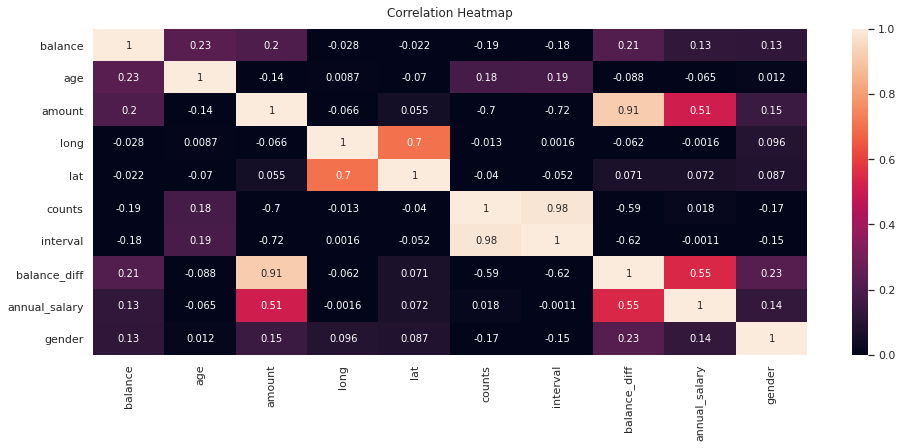

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_df.corr(), vmin=0, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Text(0, 0.5, 'Salary')

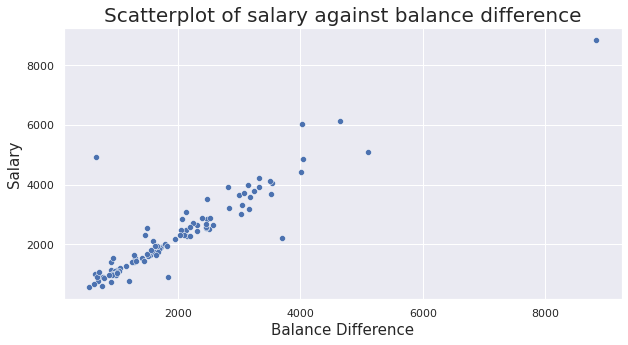

In [ ]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
age_salary_graph = sns.scatterplot(x="balance_diff", y="amount", data=final_df)
age_salary_graph.axes.set_title("Scatterplot of salary against balance difference",fontsize=20)
age_salary_graph.set_xlabel("Balance Difference", fontsize=15)
age_salary_graph.set_ylabel("Salary", fontsize=15)

Text(0, 0.5, 'Annual Salary')

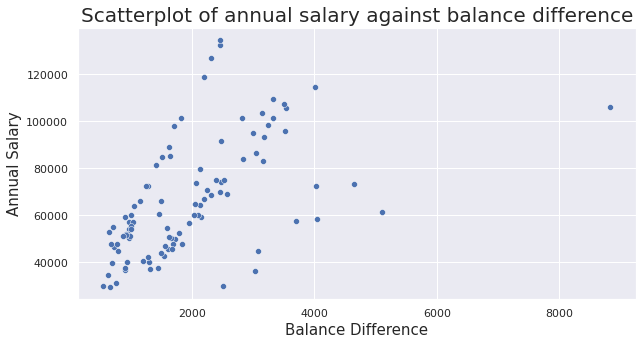

In [ ]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
age_salary_graph = sns.scatterplot(x="balance_diff", y="annual_salary", data=final_df)
age_salary_graph.axes.set_title("Scatterplot of annual salary against balance difference",fontsize=20)
age_salary_graph.set_xlabel("Balance Difference", fontsize=15)
age_salary_graph.set_ylabel("Annual Salary", fontsize=15)

## Predict

### Linear Regression

In [ ]:
# Split data
train, test = train_test_split(final_df, test_size=0.2)
X = train[['balance_diff', 'balance','age']]
y = train['amount']
X_test = test[['balance_diff', 'balance','age']]
y_test = test['amount']

# Instantiate model
lm = LinearRegression()

# Fit model
lm.fit(X,y)

# Print the R-squared value for the model
lm.score(X, y)

0.8571603852830866

In [ ]:
# Predict
y_predict = lm.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

532.9686358498546


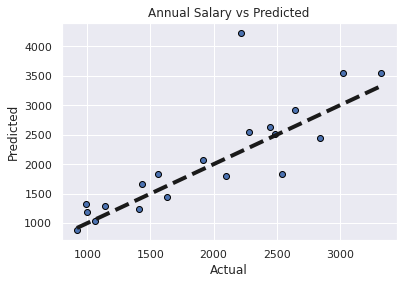

In [ ]:
# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()

### Decision Tree Regressor

In [ ]:
# Instantiate model
model =  DecisionTreeRegressor(max_depth=5,random_state=0)

# Fit model
model.fit(X,y)

# Print the R-squared value for the model
model.score(X, y)

0.9902844938654713

In [ ]:
# Predict
y_predict_2 = model.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict_2)))

608.7845007304369


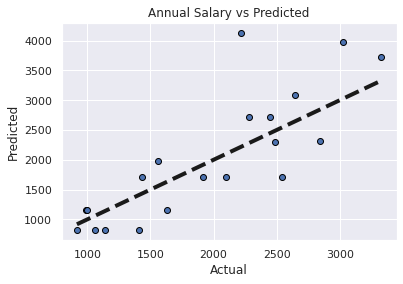

In [ ]:
# Plot of predicted salary against actual salary
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict_2, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Annual Salary vs Predicted")
plt.show()